In [89]:
import numpy as np
import urllib
import io
import shutil
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from matplotlib import pyplot as plt
from PIL import Image
!pip install rpy2
%matplotlib inline

In [90]:
#chay cell nay neu nhu can up hhinh tu thiet bi
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [91]:

import time

def getImage(pathfile):
    image = Image.open(pathfile)

    rgb_array = np.array(image).reshape(-1, 3)

    width, height = image.size

    return rgb_array, width, height

def showImage(inPixels, width, height):
  outPixels = np.array(inPixels, dtype=np.uint8).reshape(height, width, 3)

  return Image.fromarray(outPixels)

In [92]:
def convert_Rgb2Gray(inPixels, width, height):
    outPixels = []

    # gray = 0.299*red + 0.587*green + 0.114*blue
    for r in range(height):
        for c in range(width):
            i = r * width + c
            gray_value = round((0.299 * inPixels[i][0] + 0.587 * inPixels[i][1] + 0.114 * inPixels[i][2]),3)
            outPixels.append([gray_value, gray_value, gray_value])

    return outPixels

In [93]:
def detect_edges(in_pixels, width, height):
    filter_width = 3
    x_sobel_filter = [1, 0, -1, 2, 0, -2, 1, 0, -1] # Bộ lọc Sobel theo trục x
    y_sobel_filter = [1, 2, 1, 0, 0, 0, -1, -2, -1] # Bộ lọc Sobel theo trục y

    out_pixels = []

    for out_pixels_r in range(height):
        for out_pixels_c in range(width):
            x_sobel_pixel = 0
            y_sobel_pixel = 0

            for filter_r in range(filter_width):
                for filter_c in range(filter_width):
                    x_sobel_filter_val = x_sobel_filter[filter_r * filter_width + filter_c]
                    y_sobel_filter_val = y_sobel_filter[filter_r * filter_width + filter_c]

                    in_pixels_r = out_pixels_r - filter_width // 2 + filter_r
                    in_pixels_c = out_pixels_c - filter_width // 2 + filter_c

                    in_pixels_r = min(max(0, in_pixels_r), height - 1)
                    in_pixels_c = min(max(0, in_pixels_c), width - 1)

                    in_pixel = in_pixels[in_pixels_r * width + in_pixels_c]

                    x_sobel_pixel += x_sobel_filter_val * in_pixel[0]
                    y_sobel_pixel += y_sobel_filter_val * in_pixel[0]

            detect_value = abs(x_sobel_pixel) + abs(y_sobel_pixel)

            out_pixels.append(detect_value)

    return out_pixels

In [94]:
def get_least_importance_pixels(in_pixels, width, height):
    out_pixels = [0] * (width * height)

    for c in range(width):
        index = (height - 1) * width + c
        out_pixels[index] = in_pixels[index] # giữ nguyên kết quả hàng cuối cùng

    for r in range(height - 2, -1, -1): # duyệt từng hàng từ dưới lên
        for c in range(width):
            index = r * width + c

            if c == 0: # Trường hợp vị trí pixel ở cột đầu tiên
                min_val = min(out_pixels[index + width], out_pixels[index + width + 1])
                min_val += in_pixels[index]
                out_pixels[index] = min_val
                continue

            if c == width - 1: # Trường hợp vị trí pixel ở cột cuối cùng
                min_val = min(out_pixels[index + width], out_pixels[index + width - 1])
                min_val += in_pixels[index]
                out_pixels[index] = min_val
                continue

            # Tìm min cho pixel đang duyệt
            min_val = min(out_pixels[index + width], out_pixels[index + width + 1], out_pixels[index + width - 1])
            min_val += in_pixels[index]
            out_pixels[index] = min_val

    return out_pixels

In [95]:
def find_seam(in_pixels, width, height):
    path_seam = [0] * height

    min_val = in_pixels[0]
    index = 0
    path_seam[0] = index


    for c in range(width): # duyệt để tìm Pixel trong hàng đầu tiên có độ quan trọng thấp nhất
        if in_pixels[c] < min_val:
            min_val = in_pixels[c]
            index = c

    path_seam[0] = index

    for r in range(1, height):
        if index % width == 0:
            if in_pixels[index + width] <= in_pixels[index + width + 1]:
                path_seam[r] = index + width
                index = index + width
            else:
                path_seam[r] = index + width + 1
                index = index + width + 1
            continue

        if index % width == (width - 1):
            if in_pixels[index + width] <= in_pixels[index + width - 1]:
                path_seam[r] = index + width
                index = index + width
            else:
                path_seam[r] = index + width - 1
                index = index + width - 1
            continue

        location = index + width - 1
        min_val = in_pixels[index + width - 1]
        path_seam[r] = index + width - 1

        if in_pixels[index + width] < min_val:
            min_val = in_pixels[index + width]
            path_seam[r] = index + width
            location = index + width

        if in_pixels[index + width + 1] < min_val:
            path_seam[r] = index + width + 1
            location = index + width + 1

        index = location

    return path_seam

In [96]:
def remove_pixels(in_pixels, width, height, seam_path):
  index_seam = 0
  out_pixels = []
  for r in range(height):
    for c in range(width):
      index = r * width + c

      if (index_seam < height) and (index == seam_path[index_seam]):
        index_seam += 1
      else:
        out_pixels.append(in_pixels[index])
  width -= 1
  return out_pixels, width, height

In [97]:
def resize_image(pathfile, k):
  inPixels, width, height = getImage(pathfile)

  for i in range(k):
    grayPixels = convert_Rgb2Gray(inPixels, width, height)

    importancePixels = detect_edges(grayPixels, width, height)

    leastImportancePixels = get_least_importance_pixels(importancePixels, width, height)

    pathSeam = find_seam(leastImportancePixels, width, height)

    inPixels, width, height = remove_pixels(inPixels, width, height, pathSeam)

  return inPixels, width, height

Image size: 749 x 500


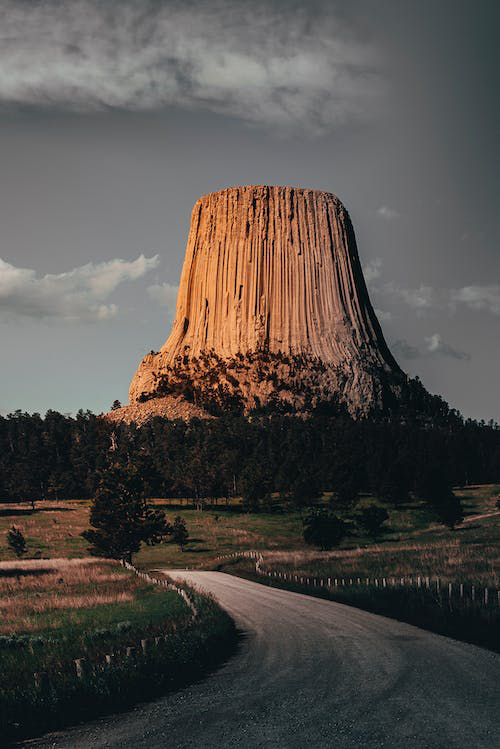

In [98]:
pathFile = "/content/anh1.jpeg"

image, width, height = getImage(pathFile)
print("Image size:",height,"x",width)
showImage(image, width, height)

Result:
Image Size: 749 x 480
runtime: 181.3450448513031 s


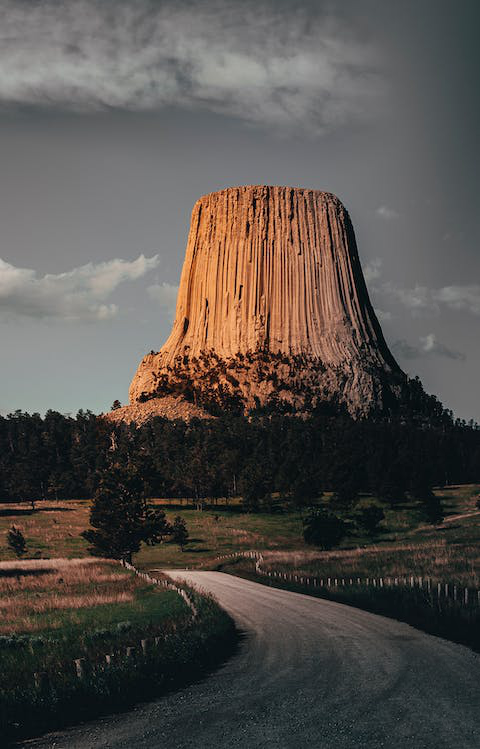

In [99]:
print("Result:")

start_time = time.time()
image, width, height = resize_image(pathFile, 20)
end_time = time.time()

print("Image Size:",height,"x",width)
execution_time = end_time - start_time
print("runtime:", execution_time, "s")

showImage(image, width, height)

## Crop ngang

In [100]:
def rot90(m, k=1, axes=(0,1)):
    axes = tuple(axes)
    if len(axes) != 2:
        raise ValueError("len(axes) must be 2.")

    m = np.asanyarray(m)

    if axes[0] == axes[1] or np.absolute(axes[0] - axes[1]) == m.ndim:
        raise ValueError("Axes must be different.")

    if (axes[0] >= m.ndim or axes[0] < -m.ndim
        or axes[1] >= m.ndim or axes[1] < -m.ndim):
        raise ValueError("Axes={} out of range for array of ndim={}."
            .format(axes, m.ndim))

    k %= 4

    if k == 0:
        return m[:]
    if k == 2:
        return flip(flip(m, axes[0]), axes[1])

    axes_list = np.arange(0, m.ndim)
    (axes_list[axes[0]], axes_list[axes[1]]) = (axes_list[axes[1]],
                                                axes_list[axes[0]])

    if k == 1:
        return np.transpose(flip(m,axes[1]), axes_list)
    else:
        # k == 3
        return flip(np.transpose(m, axes_list), axes[1])

def flip(m, axis):
    if not hasattr(m, 'ndim'):
        m = np.asarray(m)
    indexer = [slice(None)] * m.ndim
    try:
        indexer[axis] = slice(None, None, -1)
    except IndexError:
        raise ValueError("axis=%i is invalid for the %i-dimensional input array"
                         % (axis, m.ndim))
    return m[tuple(indexer)]

In [101]:
# inPixels, width, height = getImage(pathFile)
# grayPixels = convert_Rgb2Gray(inPixels, width, height)
# inPixels

array([[107, 107, 107],
       [107, 107, 107],
       [107, 107, 107],
       ...,
       [ 45,  56,  58],
       [ 44,  55,  57],
       [ 44,  55,  57]], dtype=uint8)

In [102]:
# inPixels = rot90(inPixels, 1, (0, 1)) #xoay goc 90 do 1 lan
# #grayPixels = convert_Rgb2Gray(inPixels, width, height)
# inPixels

array([[107, 107, 107, ...,  58,  57,  57],
       [107, 107, 107, ...,  56,  55,  55],
       [107, 107, 107, ...,  45,  44,  44]], dtype=uint8)

In [103]:
# inPixels = np.array(inPixels).reshape(-1, 3)
# inPixels

array([[107, 107, 107],
       [108, 108, 108],
       [109, 109, 101],
       ...,
       [ 41,  46,  49],
       [ 51,  50,  45],
       [ 45,  44,  44]], dtype=uint8)

In [104]:
def resize_height(pathfile, k):
    inPixels, width, height = getImage(pathfile)
    inPixels = rot90(inPixels, 1, (0, 1)) #xoay goc 90 do 1 lan
    inPixels = np.array(inPixels).reshape(-1, 3)
    for i in range(k):
      grayPixels = convert_Rgb2Gray(inPixels, width, height)

      importancePixels = detect_edges(grayPixels, width, height)

      leastImportancePixels = get_least_importance_pixels(importancePixels, width, height)

      pathSeam = find_seam(leastImportancePixels, width, height)

      inPixels, width, height = remove_pixels(inPixels, width, height, pathSeam)
    inPixels = rot90(image, 3, (0, 1))# xoay goc 90 do 3 lan quay lai vi tri cu
    inPixels = np.array(inPixels).reshape(-1, 3)
    return inPixels, width, height

Result:
Image Size: 749 x 480
runtime: 171.5486102104187 s


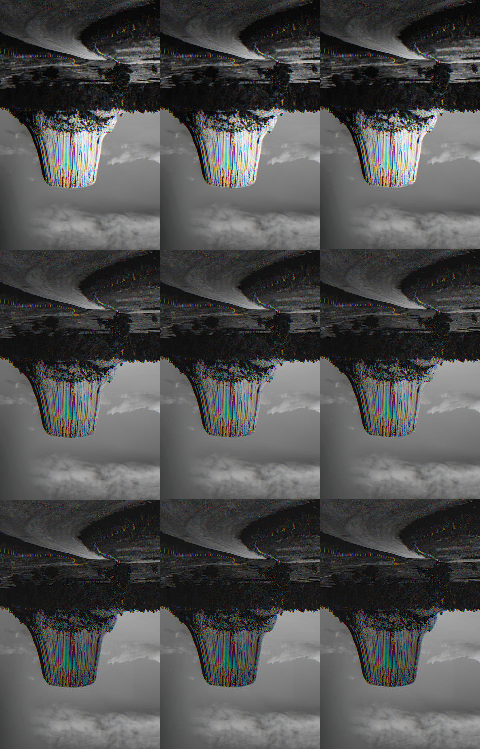

In [105]:
print("Result:")

start_time = time.time()
image, width, height = resize_height(pathFile,20)
end_time = time.time()

print("Image Size:",height,"x",width)
execution_time = end_time - start_time
print("runtime:", execution_time, "s")

showImage(image, width, height)